In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.table import Table
# Do with newly inspected table, and categories
vis_inp_table = '/Users/yingkangzhang/wps_workspace/wps_cloud/0-hi_z/inspected_catalog2.csv'
table_vi = pd.read_csv(vis_inp_table, encoding='gbk')
table_vi['Sample']
df_good = table_vi[(table_vi['Sample'].str.contains('good'))].reset_index(drop=True)
# df_cand = table_vi[(table_vi['Sample'].str.contains('cand B')) | (table_vi['Sample'].str.contains('cand C'))].reset_index(drop=True)
df_cand = table_vi[(table_vi['Sample'].str.contains('cand'))].reset_index(drop=True)
df_reje = table_vi[(table_vi['Sample'].str.contains('rejected B')) | (table_vi['Sample'].str.contains('rejected C'))].reset_index(drop=True)

### analysis1: separation distribution

In [2]:
def just_show_distancev2(survey = 'first',
                        df_table = table_vi,
                        show_uplim = 3,
                        bin_size = 0.1,
    ):
    n_bins = int(show_uplim / bin_size)  # Number of bins based on

    df_good = table_vi[(table_vi['Sample'].str.contains('good'))].reset_index(drop=True)
    # df_cand = table_vi[(table_vi['Sample'].str.contains('cand B')) | (table_vi['Sample'].str.contains('cand C'))].reset_index(drop=True)
    df_cand = table_vi[(table_vi['Sample'].str.contains('cand'))].reset_index(drop=True)
    df_reje = table_vi[(table_vi['Sample'].str.contains('rejected B')) | (table_vi['Sample'].str.contains('rejected C'))].reset_index(drop=True)

    data_1 = df_good['sep_'+survey]
    data_2 = df_cand['sep_'+survey]
    data_3 = df_reje['sep_'+survey]
    data_1 = data_1.dropna(); data_2 = data_2.dropna(); data_3 = data_3.dropna()
    print(f"The number of data points: {len(data_1)}")
    print(f"The number of data points cand: {len(data_2)}")
    print(f"The number of data points reje: {len(data_3)}")

    plt.figure(figsize=(9, 6))
    plt.hist([data_1,data_2,data_3], bins=n_bins, range=(0, show_uplim),
         stacked=True,
         linewidth=0.2,
         edgecolor='black',
         color=['steelblue', 'darkorange', 'lightcoral'],
         label=[f'Separation_{survey} (good)', f'Separation_{survey} (candidate)', f'Separation_{survey} (rejected)'])
    survey_name=survey.upper()
    plt.title(f'{survey_name}-SDSS', fontsize=20)
    plt.xlabel(f'Separation (arcsec)', fontsize=20)
    plt.ylabel('Number of Sources', fontsize=20)
    # using log scale for y-axis
    plt.xlim(0, show_uplim)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig(f"./figures/SEP_{survey_name}_SDSS.pdf", format='pdf', dpi=200)
    plt.show()

The number of data points: 94
The number of data points cand: 51
The number of data points reje: 225


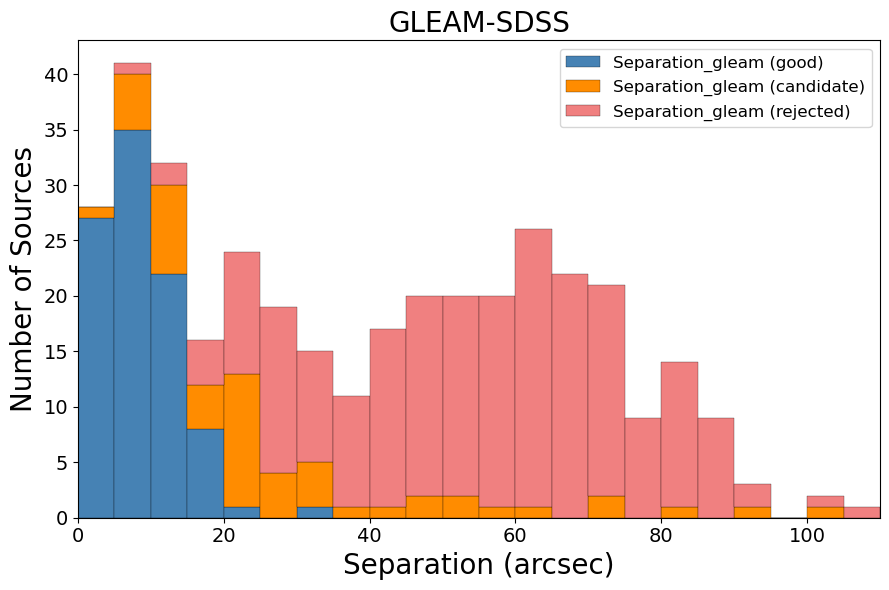

In [3]:
# just_show_distancev2(survey = 'first', show_uplim = 3, bin_size = 0.1)
# just_show_distancev2(survey = 'nvss', show_uplim = 25, bin_size = 0.5)
just_show_distancev2(survey = 'gleam', show_uplim = 110, bin_size = 5)
# just_show_distancev2(survey = 'racs', show_uplim = 14, bin_size = 0.5)

### figure new1: Likeli new

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.table import Table

#Define the function

def calc_r(ra_opt, dec_opt, ra_radio, dec_radio, sigma_ra_opt, sigma_dec_opt, sigma_ra_radio, sigma_dec_radio):
    """
    Calculate the normalized distance r between optical and radio sources.
    Parameters:
    ras and decs (float): Right Ascension and Declination of the source (both optical and radio) in degrees.
    sigmas (float): Uncertainties in Right Ascension and Declination for both optical and radio sources in arcseconds.
    Returns:
    float: Normalized distance r, based on arcsecond calculations.
    """

    sep_ra = (ra_opt - ra_radio) * np.cos(np.deg2rad(dec_opt))  # Convert to radians for cos
    sep_dec = dec_opt - dec_radio

    # before calculating r, change all variables to arcseconds
    sep_ra *= 3600  # Convert degrees to arcseconds
    sep_dec *= 3600  # Convert degrees to arcseconds
    r = np.sqrt(sep_ra**2/(sigma_ra_opt**2 + sigma_ra_radio**2) + sep_dec**2/(sigma_dec_opt**2 + sigma_dec_radio**2))

    return r

def rayleigh_pdf(x, sigma):
    # The Rayleigh probability density function (PDF)
    return (x / sigma**2) * np.exp(-x**2 / (2 * sigma**2))

In [2]:
# Get input table full, for parameters
final_table_path = 'final_matched_highz_catalogue.fits'
ref_table_patha = 'matched_radio_highz_catalogue.fits'
ref_table_pathb = 'ref_o1r1234_all_sources.fits'
with fits.open(final_table_path) as hdul:
    data = hdul[1].data
    table_fi = Table(data)
df_fi = table_fi.to_pandas()

with fits.open(ref_table_patha) as hdul:
    data = hdul[1].data
    table_fa = Table(data)
df_ref_a = table_fa.to_pandas()


with fits.open(ref_table_pathb) as hdul:
    data = hdul[1].data
    table_fb = Table(data)
df_ref_b = table_fb.to_pandas()

vis_inp_table = '/Users/yingkangzhang/wps_workspace/wps_cloud/0-hi_z/inspected_catalog2.csv'
df_vi = pd.read_csv(vis_inp_table, encoding='gbk')
df_vi

,sdss_name,sdss_ra,sdss_dec,sdss_z,sdss_source_z,sdss_zwarning,z_reliable_flag,FIRST,match_tier_first,Fpeak_first,...,sep_gleam,resolve_gleam,sdss_name.1,Sample,Note1,Note2,first_code,nvss_code,racs_code,gleam_code
0,000017.32-044502.3,0.072189,-4.750661,3.275,PIPE,0,2,J000017.3-044501,1.0,1.69,...,NaN,NaN,000017.32-044502.3,cand A,NaN,weak,U,ND,U,ND
1,000023.29+014501.8,0.097058,1.750519,3.097,PIPE,0,2,J000023.2+014501,1.0,2.36,...,NaN,NaN,000023.29+014501.8,cand A,NaN,NaN,U,U,SE,ND
2,000051.56+001202.5,0.214857,0.200716,3.865,VI,4,1,J000051.5+001202,1.0,2.74,...,NaN,NaN,000051.56+001202.5,good,NaN,NaN,U,SE,ND,ND
3,000055.68-100143.6,0.232028,-10.028793,3.264,VI,0,1,NaN,NaN,NaN,...,65.593,1.084,000055.68-100143.6,rejected B,cp dominate 4,NaN,ND,ND,ND,Ucp
4,000144.88-095630.8,0.437025,-9.941897,3.347,VI,0,1,NaN,NaN,NaN,...,20.920,0.925,000144.88-095630.8,rejected B,cp closer,NaN,ND,ND,ND,Ucp
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2383,235744.14+190433.5,359.433942,19.075997,3.454,VI,0,1,NaN,NaN,NaN,...,NaN,NaN,235744.14+190433.5,good B,NaN,affected by cp,ND,Uaf,ND,ND
2384,235758.55+140201.8,359.493964,14.033842,4.332,VI,68,1,NaN,NaN,NaN,...,NaN,NaN,235758.55+140201.8,good,NaN,NaN,ND,U,U,ND
2385,235802.27-035639.2,359.509482,-3.944235,3.322,PIPE,64,3,NaN,NaN,NaN,...,60.429,0.966,235802.27-035639.2,rejected A,redshift unreliable,NaN,NaN,Ucp,Ucp,Ucp
2386,235842.93-062515.4,359.678907,-6.420946,3.216,VI,0,1,J235842.9-062515,1.0,2.35,...,NaN,NaN,235842.93-062515.4,good B,NaN,3 affected by cp,U,Uaf,U,ND


In [3]:


# select subset with good only

def filter_df(df1,df_full):
    df1=df1[(df1['Sample'].str.contains('good'))].reset_index(drop=True)
    df_full=df_full[(df_full['sdss_name'].isin(df1['sdss_name']))].reset_index(drop=True)
    return df1,df_full

df_good,df_full_good= filter_df(df_vi, df_ref_a)
df_full_good

,sdss_name,sdss_ra,sdss_dec,sdss_class,sdss_z,sdss_source_z,sdss_z_pipe,sdss_zwarning,sdss_z_vi,sdss_z_conf,...,e_amaj0_r4,e_bmin0_r4,e_PA0_r4,Separation_racs,GrpSize_before_racs,group_z_min_racs,group_z_max_racs,GroupID_racs,GroupSize_racs,match_tier_racs
0,102651.46+590628.0,156.714441,59.107796,QSO,3.407,VI,3.407636,0,3.407,3.0,...,NaN,NaN,NaN,NaN,-2147483648,NaN,NaN,-2147483648,-2147483648,-2147483648
1,100025.33+590459.6,150.105554,59.083246,QSO,3.502,VI,3.502315,0,3.502,3.0,...,NaN,NaN,NaN,NaN,-2147483648,NaN,NaN,-2147483648,-2147483648,-2147483648
2,102032.50+585849.2,155.135452,58.980348,QSO,3.421,VI,3.421338,0,3.421,3.0,...,NaN,NaN,NaN,NaN,-2147483648,NaN,NaN,-2147483648,-2147483648,-2147483648
3,111014.02+585744.1,167.558426,58.962254,QSO,3.102,VI,3.101355,0,3.102,3.0,...,NaN,NaN,NaN,NaN,-2147483648,NaN,NaN,-2147483648,-2147483648,-2147483648
4,155307.12+585013.5,238.279675,58.837088,QSO,3.709,VI,3.729830,4,3.709,3.0,...,NaN,NaN,NaN,NaN,-2147483648,NaN,NaN,-2147483648,-2147483648,-2147483648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1631,221304.34+141535.7,333.268094,14.259933,QSO,3.559,VI,3.559496,0,3.559,3.0,...,2.21,1.90,44.840000,1.678409,1,NaN,NaN,-2147483648,1,1
1632,230857.19+234006.0,347.238317,23.668349,QSO,3.387,VI,3.346591,0,3.387,3.0,...,7.23,5.02,42.330002,4.354491,1,NaN,NaN,-2147483648,1,1
1633,230650.41+253331.1,346.710057,25.558644,QSO,3.135,VI,3.134712,0,3.135,3.0,...,5.10,3.20,30.469999,1.240525,1,NaN,NaN,-2147483648,1,1
1634,231032.87-013329.5,347.636986,-1.558213,QSO,3.048,VI,3.047578,0,3.048,3.0,...,6.88,4.73,47.029999,3.573411,1,NaN,NaN,-2147483648,1,1


In [4]:
def make_df_likeli(df, survey):
    ra_opt = df['sdss_ra']; dec_opt = df['sdss_dec']
    sigma_ra_opt = 0.1 ;sigma_dec_opt = 0.1
    if survey == 'first':
        ra_radio = df['RA_deg_r1']; dec_radio = df['DEC_deg_r1']
        sigma_ra_radio = 0.4; sigma_dec_radio = 0.4
    elif survey == 'nvss':
        ra_radio = df['RA_deg_r2']; dec_radio = df['DEC_deg_r2']
        sigma_ra_radio = df['e_RAJ2000_r2']; sigma_dec_radio = df['e_DEJ2000_r2']
    elif survey == 'gleam':
        ra_radio = df['RA_deg_r3']; dec_radio = df['DEC_deg_r3']
        sigma_ra_radio = df['e_RAJ2000_r3']; sigma_dec_radio = df['e_DEJ2000_r3']
    elif survey == 'racs': 
        ra_radio = df['RA_deg_r4']; dec_radio = df['DEC_deg_r4']
        sigma_ra_radio = df['e_RAJ2000_r4']; sigma_dec_radio = df['e_DEJ2000_r4']
    else:
        raise ValueError("Invalid survey type. Choose from 'first', 'nvss', 'gleam', or 'racs'.")
    likeli_col = f'likeli_{survey}'
    df[likeli_col] = calc_r(ra_opt, dec_opt, ra_radio, dec_radio, sigma_ra_opt, sigma_dec_opt, sigma_ra_radio, sigma_dec_radio)
    print(f"Calculated likelihood r for {survey} survey.")
    return df

df_good_likeli = make_df_likeli(df_full_good, 'first')
df_good_likeli = make_df_likeli(df_good_likeli, 'nvss')
df_good_likeli = make_df_likeli(df_good_likeli, 'gleam')
df_good_likeli = make_df_likeli(df_good_likeli, 'racs')
# before saving to csv, reduce the long floats to 8 digits in case excel mis understand them
df_good_likeli_out = df_good_likeli.copy()
df_good_likeli_out.replace([-32768,-2147483648], 'NA', inplace=True)
df_good_likeli_out = df_good_likeli_out.round(8)
df_good_likeli_out.to_csv('df_good_likeli_after.csv', index=False)

df_good_likeli.columns
df_good_likeli.shape

Calculated likelihood r for first survey.
Calculated likelihood r for nvss survey.
Calculated likelihood r for gleam survey.
Calculated likelihood r for racs survey.


(1636, 100)

In [5]:
from scipy.stats import rayleigh, kstest
from scipy.optimize import curve_fit

def smooth_weight(x, center=1.0, width=0.5):
    # 高斯核权重：中心center，宽度控制参数width
    return np.exp(-0.5 * ((x - center) / width)**2)

def custom_weight(x, center=1.0, low_bound=0.5, up_bound=1.5):
    if low_bound <= x <= up_bound:
        return 1.0
    else:
        return 1 / ((x - center) ** 2)

# first, r range(0,5), can set to 3, bins=30
# nvss, r range(0,200) , can set to 60, bins=60
# gleam, not sure
# racs, r range(0,100), can set to 40, bins=40

def make_likeli_plot(survey = 'first',
                     df_in = df_good_likeli,
                     data_uplim = 5,
                     show_uplim = 3,
                     bin_size = 0.1,
                     t1_only = False
    ):
    n_bins = int(data_uplim / bin_size)  # Number of bins based on

    df_block_t1  = df_in[df_in['match_tier_'+survey] == 1].reset_index(drop=True)
    df_block_t23  = df_in[df_in['match_tier_'+survey] >= 2].reset_index(drop=True)
    df_block_tot = df_in[df_in['match_tier_'+survey] >= 1].reset_index(drop=True)

    data= df_in['likeli_'+survey]
    # data_t23 = df_block_t23['likeli_'+survey]
    # data = df_block_tot['likeli_'+survey]
    data=data.dropna()
    #data_t23 = data_t23.dropna()
    print(f"The number of data points: {len(data)}")

    data_r = data[data < data_uplim]
    hist, bin_edges = np.histogram(data_r, bins=n_bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    # print(hist)
    # print(bin_edges)
    # print(bin_centers)
    weights = np.array([smooth_weight(x) for x in bin_centers])

    popt, pcov = curve_fit(rayleigh_pdf, bin_centers, hist, sigma=1/weights, absolute_sigma=False) 
    sigma_fit = popt[0]
    print(f"拟合参数 sigma = {sigma_fit:.4f}")

    # Make the axis for plot
    plt.figure(figsize=(9, 6))
    if t1_only:
        print("Plotting only tier 1 sources.")
        plt.hist(data_r, bins=n_bins, range=(0, data_uplim),
                edgecolor='black',
                # density=True,  # Normalize the histogram
                color='steelblue',
                label='Likelihood r distribution')
    else:
        print("Plotting tier 1 and tier 2/3 sources.")
        # plt.hist([data_t1,data_t23], bins=n_bins, range=(0, data_uplim),
        plt.hist([data], bins=n_bins, range=(0, data_uplim),
                 stacked=True,
                 #   density=True,  # Normalize the histogram
                 edgecolor='black',
                 color=['steelblue'],
                 label=['r distribution (tier 1)'])
    print("The fitting will only use tier 1 sources.")
    x = np.linspace(0, data_uplim, 500)
    y_pdf = rayleigh_pdf(x, sigma_fit)
    y_number = y_pdf * len(data_r) * bin_size  # Convert PDF to number density
    # plt.plot(x, y_pdf, 'r-', lw=2)
    plt.plot(x, y_number, 'r--', lw=2, label='Rayleigh PDF fit')
    plt.xlim(0, show_uplim)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.xlabel('Relative distance r', fontsize=20)
    plt.ylabel('Number of sources', fontsize=20)
    plt.legend(fontsize=14)
    
    plt.tight_layout()
    plt.savefig(f"{survey}_r_distribution.pdf", format='pdf', dpi=200)
    plt.show()

    scale = sigma_fit  # 替换为你的 scale 参数
    upper_bound = rayleigh.ppf(0.997, loc=0, scale=scale)
    print(f"99.7% upper bound = {upper_bound:.4f}")

    rayleigh_dist = rayleigh(scale=sigma_fit)  # 创建瑞利分布对象
    ks_stat, p_value = kstest(data_r, rayleigh_dist.cdf)
    print(f"KS检验统计量: {ks_stat:.4f}, p值: {p_value:.4f}")

In [6]:
# make_likeli_plot(survey = 'first', data_uplim = 3, show_uplim = 3, bin_size = 0.1, t1_only = False)
# make_likeli_plot(survey = 'nvss', data_uplim = 20, show_uplim = 30, bin_size = 1, t1_only = False)
# make_likeli_plot(survey = 'racs', data_uplim = 40, show_uplim = 14, bin_size = 0.5, t1_only = False)

### analysis 2: flux density and luminosity across redshifts

In [ ]:
# start to use only the good sample to make plots
# select FIRST and then NVSS data points
def select_ldata(df_table, method='first'):
    df_new = df_table.copy()
    for index, row in df_table.iterrows():
        first = row['FIRST']
        nvss = row['NVSS']
        if not pd.isna(first) and pd.isna(nvss):
            df_new.at[index, 'L_name'] = first
            df_new.at[index, 'L_flux'] = row['Fint_first']
            df_new.at[index, 'L_flux_err'] = row['Rms_first']
            df_new.at[index, 'L_survey'] = 'FIRST'
        elif pd.isna(first) and not pd.isna(nvss):
            df_new.at[index, 'L_name'] = nvss
            df_new.at[index, 'L_flux'] = row['S1.4_nvss']
            df_new.at[index, 'L_flux_err'] = row['e_S1.4_nvss']
            df_new.at[index, 'L_survey'] = 'NVSS'
        elif not pd.isna(first) and not pd.isna(nvss):
            if method == 'first':
                df_new.at[index, 'L_name'] = first
                df_new.at[index, 'L_flux'] = row['Fint_first']
                df_new.at[index, 'L_flux_err'] = row['Rms_first']
                df_new.at[index, 'L_survey'] = 'FIRST'
            elif method == 'nvss':
                df_new.at[index, 'L_name'] = nvss
                df_new.at[index, 'L_flux'] = row['S1.4_nvss']
                df_new.at[index, 'L_flux_err'] = row['e_S1.4_nvss']
                df_new.at[index, 'L_survey'] = 'NVSS'
            elif method == 'both':
                # calc the average
                df_new.at[index, 'L_name'] = f"avg{first}_{nvss}"
                df_new.at[index, 'L_flux'] = (row['Fint_first'] + row['S1.4_nvss']) / 2
                df_new.at[index, 'L_flux_err'] = (row['Rms_first'] + row['e_S1.4_nvss']) / 2
                df_new.at[index, 'L_survey'] = 'BOTH'
            else:
                raise ValueError("Method must be either 'first', 'nvss', or 'both'.")
    return df_new

# calculate Luminosity
def calc_luminosity(s,s_err,z,type='obs'):
    

### see the later version in py_imaging repo





In [ ]:
# start from z= 3 and ends at z= 7.2, bin width is 0.2
flux_data_L = df_good[(df_good['FIRST'].notna()) | (df_good['NVSS'].notna())]
flux_data1 = flux_data_L[['FIRST','Fint_first','Rms_first']].copy()
flux_data2 = flux_data_L[['NVSS','S1.4_nvss','e_S1.4_nvss']].copy()
flux_data_L

,sdss_name,sdss_ra,sdss_dec,sdss_z,sdss_source_z,sdss_zwarning,z_reliable_flag,FIRST,match_tier_first,Fpeak_first,...,sep_gleam,resolve_gleam,sdss_name.1,Sample,Note1,Note2,first_code,nvss_code,racs_code,gleam_code
0,000051.56+001202.5,0.214857,0.200716,3.865,VI,4,1,J000051.5+001202,1.0,2.74,...,NaN,NaN,000051.56+001202.5,good,NaN,NaN,U,SE,ND,ND
1,000200.93-033605.6,0.503886,-3.601581,3.154,VI,0,1,J000200.9-033605,1.0,4.56,...,NaN,NaN,000200.93-033605.6,good,NaN,NaN,U,U,U,ND
2,000221.12+002149.3,0.588001,0.363704,3.070,VI,0,1,J000221.1+002149,1.0,12.26,...,NaN,NaN,000221.12+002149.3,good,NaN,NaN,U,U,U,ND
3,000221.20+274410.3,0.588346,27.736214,3.098,VI,0,1,NaN,NaN,NaN,...,NaN,NaN,000221.20+274410.3,good,NaN,NaN,ND,U,U,ND
4,000252.72-000330.9,0.719701,-0.058607,3.679,VI,0,1,J000252.7-000331,1.0,1.70,...,NaN,NaN,000252.72-000330.9,good,NaN,NaN,U,ND,ND,ND
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1631,235654.69+301907.8,359.227908,30.318837,3.963,VI,0,1,NaN,NaN,NaN,...,NaN,NaN,235654.69+301907.8,good,NaN,NaN,ND,U,ND,ND
1632,235744.14+190433.5,359.433942,19.075997,3.454,VI,0,1,NaN,NaN,NaN,...,NaN,NaN,235744.14+190433.5,good B,NaN,affected by cp,ND,Uaf,ND,ND
1633,235758.55+140201.8,359.493964,14.033842,4.332,VI,68,1,NaN,NaN,NaN,...,NaN,NaN,235758.55+140201.8,good,NaN,NaN,ND,U,U,ND
1634,235842.93-062515.4,359.678907,-6.420946,3.216,VI,0,1,J235842.9-062515,1.0,2.35,...,NaN,NaN,235842.93-062515.4,good B,NaN,3 affected by cp,U,Uaf,U,ND


<Figure size 900x600 with 0 Axes>

In [10]:
df_data = select_ldata(flux_data_L, method='first')
df_data

,sdss_name,sdss_ra,sdss_dec,sdss_z,sdss_source_z,sdss_zwarning,z_reliable_flag,FIRST,match_tier_first,Fpeak_first,...,Note1,Note2,first_code,nvss_code,racs_code,gleam_code,L_name,L_flux,L_flux_err,L_survey
0,000051.56+001202.5,0.214857,0.200716,3.865,VI,4,1,J000051.5+001202,1.0,2.74,...,NaN,NaN,U,SE,ND,ND,J000051.5+001202,2.64,0.103,FIRST
1,000200.93-033605.6,0.503886,-3.601581,3.154,VI,0,1,J000200.9-033605,1.0,4.56,...,NaN,NaN,U,U,U,ND,J000200.9-033605,5.24,0.162,FIRST
2,000221.12+002149.3,0.588001,0.363704,3.070,VI,0,1,J000221.1+002149,1.0,12.26,...,NaN,NaN,U,U,U,ND,J000221.1+002149,12.98,0.107,FIRST
3,000221.20+274410.3,0.588346,27.736214,3.098,VI,0,1,NaN,NaN,NaN,...,NaN,NaN,ND,U,U,ND,000221+274409,33.50,1.100,NVSS
4,000252.72-000330.9,0.719701,-0.058607,3.679,VI,0,1,J000252.7-000331,1.0,1.70,...,NaN,NaN,U,ND,ND,ND,J000252.7-000331,1.59,0.097,FIRST
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1631,235654.69+301907.8,359.227908,30.318837,3.963,VI,0,1,NaN,NaN,NaN,...,NaN,NaN,ND,U,ND,ND,235654+301907,7.00,0.400,NVSS
1632,235744.14+190433.5,359.433942,19.075997,3.454,VI,0,1,NaN,NaN,NaN,...,NaN,affected by cp,ND,Uaf,ND,ND,235743+190433,8.30,0.900,NVSS
1633,235758.55+140201.8,359.493964,14.033842,4.332,VI,68,1,NaN,NaN,NaN,...,NaN,NaN,ND,U,U,ND,235758+140201,111.10,3.400,NVSS
1634,235842.93-062515.4,359.678907,-6.420946,3.216,VI,0,1,J235842.9-062515,1.0,2.35,...,NaN,3 affected by cp,U,Uaf,U,ND,J235842.9-062515,2.22,0.178,FIRST


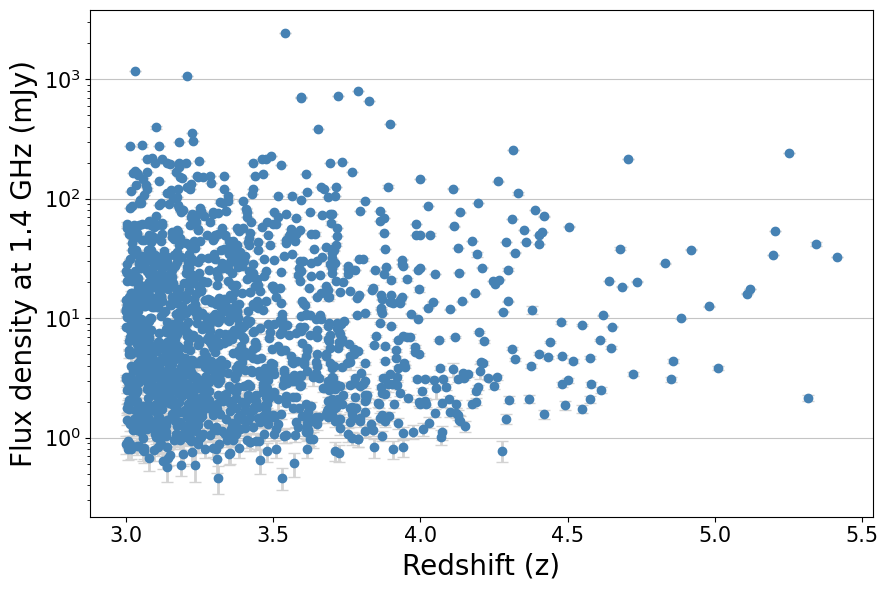

In [16]:
from matplotlib import pyplot as plt

#draw the hitogram figure for redshift distribution
plt.figure(figsize=(9, 6))

plt.errorbar(df_data['sdss_z' \
''], df_data['L_flux'], yerr=df_data['L_flux_err'], fmt='o', color='steelblue', ecolor='lightgray', elinewidth=2, capsize=4, label='Flux at 1.4 GHz')
# plt.legend(loc='upper right',fontsize=12)
# plt.title('Redshift Distribution', fontsize=20)
plt.xlabel('Redshift (z)', fontsize=20)
plt.ylabel('Flux density at 1.4 GHz (mJy)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(axis='y', alpha=0.75)
# using log scale for y-axis
plt.yscale('log')
plt.tight_layout()
plt.savefig('flux_vs_redshift.pdf', format='pdf',  dpi=300)
plt.show()